In [1]:
from scipy.io import wavfile
import soundfile
import glob
import types

# from collections import namedtuple
# Sound = namedtuple('Sound', 'filename data samplerate start end')

flac_files = glob.glob('*.FLAC')
sounds = []
for filename in flac_files:
    d, sr = soundfile.read(filename)
    sounds.append(types.SimpleNamespace(filename=filename, data=d, samplerate=sr, start=0, end=-1))

print(sounds)

[namespace(data=array([-1.32679939e-04, -1.31368637e-04, -1.38759613e-04, ...,
       -9.89437103e-06, -1.13248825e-05, -1.15633011e-05]), end=-1, filename='LM.FLAC', samplerate=48000, start=0), namespace(data=array([-4.19616699e-05, -3.39746475e-05, -3.80277634e-05, ...,
       -2.65836716e-05, -1.39474869e-05, -2.37226486e-05]), end=-1, filename='OR.FLAC', samplerate=48000, start=0), namespace(data=array([0.00289333, 0.0021379 , 0.00128698, ..., 0.00011492, 0.00011015,
       0.00012565]), end=-1, filename='16b.FLAC', samplerate=48000, start=0), namespace(data=array([ 3.09944153e-06, -7.51018524e-06,  3.76701355e-05, ...,
        4.76837158e-06,  2.62260437e-06,  5.36441803e-06]), end=-1, filename='30b.FLAC', samplerate=48000, start=0), namespace(data=array([6.43730164e-06, 1.56164169e-05, 1.54972076e-05, ...,
       5.75780869e-05, 7.14063644e-05, 7.91549683e-05]), end=-1, filename='30s.FLAC', samplerate=48000, start=0), namespace(data=array([6.02006912e-05, 5.87701797e-05, 6.008148

In [2]:
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html

import matplotlib.pyplot as plt
import numpy as np

def plot_wav(data, samplerate, start=0, end=-1, title=None, data2=None):
    plt.figure(figsize=(15,4))
    slc = data[start:end]
    length = slc.shape[0] / samplerate
    time = np.linspace(0., length, slc.shape[0])
    if len(slc.shape) == 1:
        plt.plot(time, slc, label="Mono channel")
    else:
        plt.plot(time, slc[:, 0], label="Left channel")
        plt.plot(time, slc[:, 1], label="Right channel")
    if data2 is not None:
        slc2 = data2[start:end]
        if len(slc2.shape) == 1:
            plt.plot(time, slc2, label="Data 2 Mono channel")
        else:
            plt.plot(time, slc2[:, 0], label="Data 2 Left channel")
            plt.plot(time, slc2[:, 1], label="Data 2 Right channel")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.axhline(y=0, color='k')
    plt.show()

NOISE_THRESHOLD = 0.013

def find_start_end(data):
    def i_beyond_threshold(data, noise_threshold):
        start = 0
        for i,s in enumerate(data):
            if abs(s) > noise_threshold:
                start = i
                break
        return start
    
    def i_next_crossing(data):
        last_val = 0.
        i_crossing = 0
        for i,s in enumerate(data):
            if s * last_val < 0:
                # there was a sign change, thus we crossed the axis
                i_crossing = i
                break
            else:
                last_val = s
        return i_crossing
    
    noise_threshold = max(data) * 0.05
    print(f'noise = {noise_threshold}')
    # Find the beginning of the sound that goes beyond the noise threshold
    # Then tune it to the first crossing of the axis
    start = i_beyond_threshold(data, noise_threshold)
    start += i_next_crossing(data[start:])
    # Similarly, but reverse for the end of the sound
    end = data.shape[0] - i_beyond_threshold(reversed(data), noise_threshold)
    end -= i_next_crossing(reversed(data[:end]))
    return (start, end)

import sounddevice
def play(data, samplerate, wait_for_end=True):
    audio = (data*32768).astype(np.int16)
    sounddevice.play(audio, samplerate)
    if wait_for_end:
        sounddevice.wait()
    

Matplotlib is building the font cache; this may take a moment.


In [3]:
# Preprocessing

# Remove DC offset using a narrow notch filter
# From https://stackoverflow.com/questions/6994020/remove-unknown-dc-offset-from-a-non-periodic-discrete-time-signal
import scipy.signal
a = [1 , -0.98]; b = [1,-1];
for s in sounds:
    s.data = scipy.signal.filtfilt(b,a,s.data);

# Find section of file that contains interesting sound
for s in sounds:
    s.start, s.end = find_start_end(s.data)
    # Fudge start ahead 4 seconds because these samples start to get more consistent then
    # s.start += 4 * s.samplerate
    slc = s.data[s.start:s.end]
    s.max = np.max(np.absolute(slc))
    s.rms = np.sqrt(np.mean(slc**2))
    print(f'max = {np.max(slc)}; min = {np.min(slc)}')

max_max = max([s.max for s in sounds])
max_rms = max([s.rms for s in sounds])
print(f'max_max = {max_max}, max_rms = {max_rms}')

# normalize
for s in sounds:
    s.normalized = max_rms / s.rms * s.data



noise = 0.014230843584202091
max = 0.2846168716840418; min = -0.2452092945149458
noise = 0.015165020899930107
max = 0.30330041799860213; min = -0.21982710099160338
noise = 0.014037306809164716
max = 0.2807461361832943; min = -0.24033007079559404
noise = 0.015309663337492159
max = 0.30619326674984315; min = -0.24794278721177226
noise = 0.013046049476420836
max = 0.2609209895284167; min = -0.2198927409599537
noise = 0.01390774996254035
max = 0.278154999250807; min = -0.22086626516869715
max_max = 0.30619326674984315, max_rms = 0.07781247348265534


In [4]:
# find a peak to sync on
MAX_THRESHOLD = 0.8
SKIP_TIME = 1 # seconds
# for s in sounds:
#     start = s.start + SKIP_TIME * s.samplerate
#     i_peak = i_last = 0
#     val_last = s.data[start-1]
#     delta_last = s.data[start-1] - s.data[start-2]
#     for i,val in enumerate(s.data[start:s.end]):
#         delta = val - val_last
#         if delta * delta_last < 0 and val > s.max * MAX_THRESHOLD:
#             # the waveform has changed directions and we are near an overall peak
#             i_peak = i_last
#             val_end = val
#             print(f'{s.filename} BREAK: s.max={s.max}, val_last={val_last}, val={val_end}, delta_last={delta_last}, delta={delta}, prod={delta * delta_last}')
#             break
#         else:
#             i_last = i
#             val_last = val
#     if i_peak != 0:
#         s.peak_start = i_peak + start
#     else:
#         s.peak_start = s.start
#     print(f'{s.filename}: s.start={s.start}, s.peak_start={s.peak_start}, s.max={s.max}, val_last={val_last}, val={val_end}, delta_last={delta_last}, delta={delta}')


for s in sounds:
    # start = s.start + SKIP_TIME * s.samplerate
    peaks = scipy.signal.find_peaks(s.data[s.start:s.end])
    s.peak_start = peaks[0] + s.start
    print(f's.peak_start={s.peak_start}')


s.peak_start=[338391 338395 338455 ... 814264 814318 814343]
s.peak_start=[347450 347526 347551 ... 862891 862941 862994]
s.peak_start=[325028 325038 325067 ... 742275 742320 742373]
s.peak_start=[319364 319367 319378 ... 800244 800252 800309]
s.peak_start=[376640 376693 376703 ... 879205 879241 879295]
s.peak_start=[406780 406835 406883 ... 776431 776471 776502]


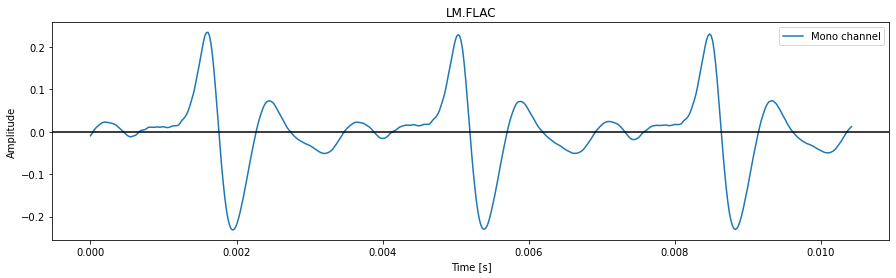

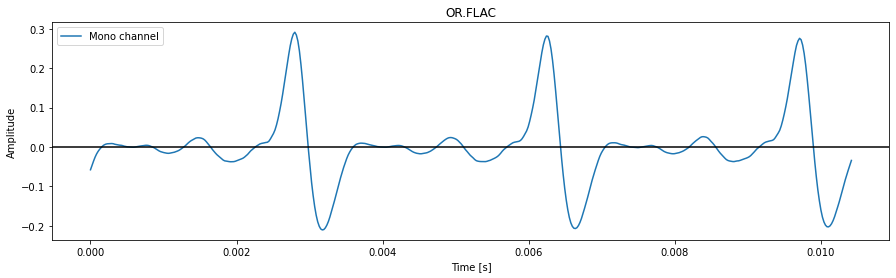

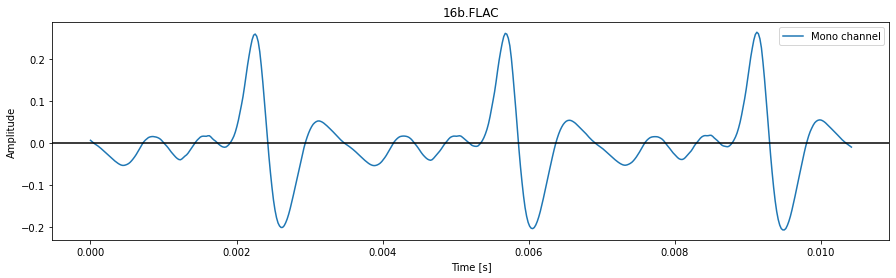

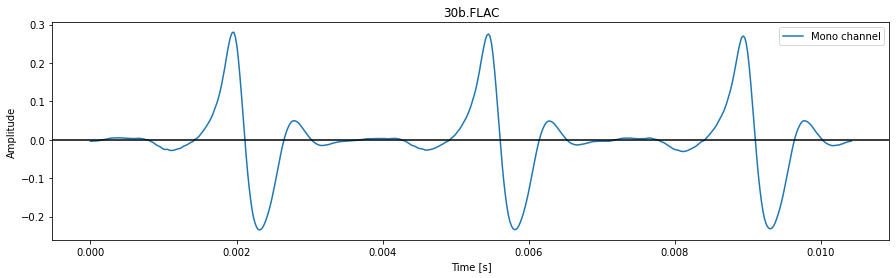

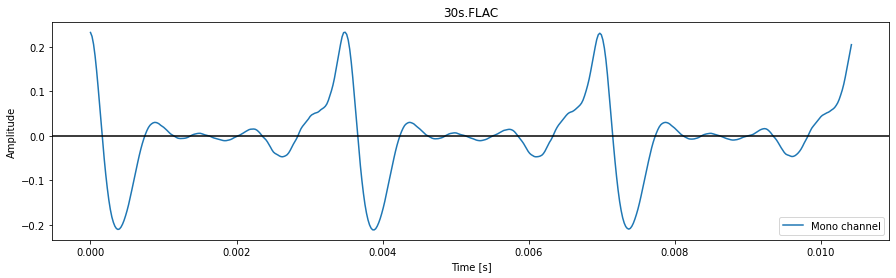

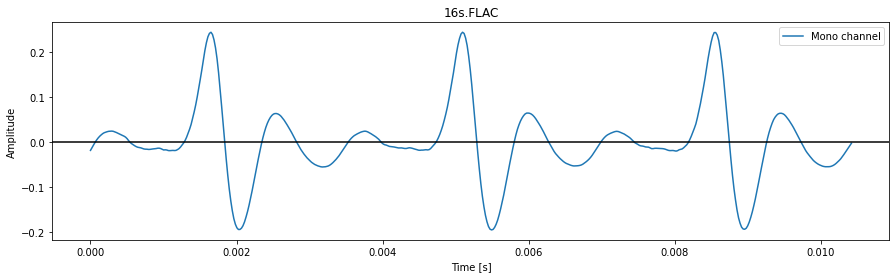

In [5]:
# Show me the data
for s in sounds:
    plot_wav(s.normalized, s.samplerate, s.start+s.samplerate, s.start+s.samplerate+500, s.filename)
    # plot_wav(s.normalized, s.samplerate, s.peak_start, s.peak_start + 500, s.filename)
    # play(s.normalized[s.start:s.end], s.samplerate)